# ME 595r - Autonomous Sytems
# Extended Kalman Filter

## Dynamic Model
This filter will estimate the states of a ground robot with velocity inputs and a sensor that measures range and bearing to landmarks. The state is parameterized as
$$ x = \begin{bmatrix}x \\ y \\ \theta \end{bmatrix} $$

The commanded input is

$$ \hat{u} = \begin{bmatrix} \hat{v} \\ \hat{\omega} \end{bmatrix} $$

The true input to the system is equal to the commanded input corrupted by noise

$$ u = \hat{u} + \xi_u $$

Where $ \xi_u $ is a zero-mean multivariate random variable with covariance

$$ \Sigma_{\xi_u} = \begin{bmatrix} \alpha_1 v_t^2 + \alpha_2 \omega_t^2 & 0 \\ 0 & \alpha_3 v_t^2 + \alpha_4 \omega_t^2 \end{bmatrix} $$

The state evolves as

$$ \bar{x}_t = f(x, u) = x_{t-1} + 
\begin{bmatrix} 
-\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) - \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
\omega_t \Delta t
\end{bmatrix} $$

For the Extended Kalman filter, we need to linearize the dynamic model about our state and our input

$$ A_d = \frac{\partial f}{\partial x} = 
\begin{bmatrix}
1 & 0 & -\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
0 & 1 & -\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
0 & 0 & 1
\end{bmatrix} $$

## Measurements and Noise
We will measure the range and bearing to landmarks

## Implementation

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
#####
# Enable this to be able to zoom plots, but it kills patches
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()
#####
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm, tqdm_notebook
import copy
#import plotly.plotly as pl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figWidth = 11
figHeight = 8

In [35]:
from scipy.stats import multivariate_normal as mvn

def wrap_each(x):
    for i, y in enumerate(x):
        x[i] = wrap(y)
    return x
        
def wrap(x):
    while x < -np.pi:
        x += 2*np.pi
    while x > np.pi:
        x -= 2*np.pi
    return x

class Particle(object):
    def __init__(self, x0, num_landmarks, g, del_g_x, R, Ts):
        self.g = g
        self.del_g_x = del_g_x
        self.n = len(x0)  # state dimension
        self.l = num_landmarks
        self.R = 1*R
        self.x = x0
        self.lx = np.zeros((2, num_landmarks))
#         self.P = np.array([1e10*np.eye(2*num_landmarks) for i in xrange(num_landmarks)])
        self.P = 1e10*np.eye(2)[:, :, None] + np.zeros((2, 2, num_landmarks))
#         self.P = self.R[:, :, None] + np.zeros((2, 2, num_landmarks))
        self.Ts = Ts

    def update(self, z, landmark_idx):
        # landmark_idx is a list of indices of landmarks that correspond to the z measurements
        # landmark_idx should be the same length as the second dimension of z
        
        # for any landmarks that haven't been initialized
        for i, idx in enumerate(landmark_idx):
            if self.lx[0, idx] == 0.:
                self.lx[:, idx] = self.x[:2] + np.array([z[0, i]*np.cos(z[1, i] + self.x[2]), 
                                                         z[0, i]*np.sin(z[1, i] + self.x[2])])
#                 self.P[:, :, idx] = np.copy(self.R)

        C = self.del_g_x(self.x, self.lx[:, landmark_idx])
        
        # use Einstein summation notation to do some crazy linalg
        # for example np.einsum('mnr,ndr->mdr', A, B)
        # does matrix multiply on first two dimensions, broadcasting the operation along the third
        
        # S = C.dot(self.P.dot(C.T)) + self.R
        # C_T = np.einsum('ijk->jik', C)
#         print(C.shape)
#         print(self.P[:, :, landmark_idx].shape)
        # similar to P.dot(C.T)
        S1 = np.einsum('mnr,dnr->mdr', self.P[:, :, landmark_idx], C)
#         print(S1.shape)
        S = np.einsum('mnr,ndr->mdr', C, S1) + self.R[:, :, None]
        S_inv = np.zeros_like(S)
        for i in xrange(S.shape[-1]):
            S_inv[:, :, i] = np.linalg.inv(S[:, :, i])
        # now do some Einstein stuff for the rest
        # self.K = self.P.dot(C.T).dot(np.linalg.inv(S))
        K1 = np.einsum('mnr,dnr->mdr', self.P[:, :, landmark_idx], C)
        K = np.einsum('mnr,ndr->mdr', K1, S_inv)
        z_hat = self.g(self.x, self.lx[:, landmark_idx])
        res = z - z_hat
        res[1, :] = wrap_each(res[1, :])
        # self.lx[:, landmark_idx] = self.lx[:, landmark_idx] + self.K.dot(res)
        
        
        
#         Q1 = np.einsum('nmr,ndr->mdr', C, self.P[:, :, landmark_idx])
#         Q = np.einsum('mnr,ndr->mdr', Q1, C) + self.R[:, :, None]
        
        w = 0;
        for i in xrange(S.shape[-1]):
            w += mvn.logpdf(res[:, i], mean=(0, 0), cov=S[:, :, i])
#         print("z: {}".format(z))
#         print("zHat: {}".format(z_hat[1]))
#         print("x: {}".format(self.x))
#         print("res: {}".format(res[1]))
        
        # update the estimates
        self.lx[:, landmark_idx] = self.lx[:, landmark_idx] + np.einsum('mnr,nr->mr', K, res)
        # self.P = (np.eye(self.n + 2*self.l) - self.K.dot(C_aug)).dot(self.P)
        # update the covariances
        P1 = np.eye(2)[:, :, None] - np.einsum('mnr,ndr->mdr', K, C)
        self.P[:, :, landmark_idx] = np.einsum('mnr,ndr->mdr', P1, self.P[:, :, landmark_idx])
        
        return w
        

In [36]:
from scipy.stats import multivariate_normal as mvn
import copy

class FastSLAM(object):
    def __init__(self, x0, num_particles, state_dim, input_dim, num_landmarks, f, g, del_g_x, R, Ts, Q=None, Qu=None):
        self.f = f
        self.g = g
        self.n = state_dim
        self.m = input_dim  # input dimension
        self.num_particles = num_particles
        self.num_landmarks = num_landmarks

        self.Qu = Qu
        self.Q = Q
        self.X = []
        P0 = 0.0*np.eye(3)
        for i in xrange(self.num_particles):
            x0_p = np.random.multivariate_normal(x0, P0)
            self.X.append(Particle(x0_p, num_landmarks, g, del_g_x, R, Ts))
        self.best = self.X[0]
        self.Ts = Ts
        
    def lowVarSample(self, w):
        Xbar = []
        M = self.num_particles
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in xrange(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            Xbar.append(copy.deepcopy(self.X[i]))
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self, u):
        self.u = u
        
        # input noise case
#         uHat = u[:, np.newaxis] + np.zeros((self.m, self.num_particles))
        uHat = u
        
        # propagate the particles
#         pdb.set_trace()
        for particle in self.X:
            if self.Qu is not None:
                uHat += np.random.multivariate_normal(np.zeros(self.m), self.Qu(u))
            particle.x = self.f(particle.x, uHat, self.Ts)
            if self.Q is not None:
                particle.x += np.random.multivariate_normal(np.zeros(self.n), self.Q)
#         self.X = self.f(self.X, uHat, dt)
        
        
        

#         self.x = np.mean(self.X, axis=1)[:, np.newaxis]
#         self.P = np.cov(self.X, rowvar=True)
#         print(self.X.shape)
#         print(self.P.shape)
#         print(self.x)
        
        
    def update(self, z, landmark_idx):

        
        
        w = np.zeros(self.num_particles)
        
        for i, x in enumerate(self.X):
#             wi = 0.9*mvn.pdf(zHat[:, i, :].T, mean=z[:, i], cov=self.R).T
#             # add in a 1% mixture of uniform over range measurements between 1m and 11m
#             wi += 0.1*0.1
#             w += np.log(wi)
            w[i] = x.update(z, landmark_idx)
#             print(w)
        # logsumexp
#         print("log w: {}".format(w))
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
        
        self.best_idx = np.argmax(w)        
        best = self.X[self.best_idx]
#         print("w: {}".format(w))
        
        unique = self.lowVarSample(w)
        print(unique)
        # add some noise to account for sparsity in particles
#         if unique/self.num_particles < 0.5:
#             Q = self.P/((self.num_particles*unique)**(1/self.n))
#             self.X += np.random.multivariate_normal(np.zeros(self.n), Q, size=self.num_particles).T

        
        # grab the most likely particle before resampling instead
#         self.x = np.mean(self.X, axis=1)[:, np.newaxis]
#         self.P = np.cov(self.X, rowvar=True)
        self.best = best
        

In [39]:
# initialize inputs and state truth

Ts = 0.1
Tend = 30

num_particles = 25
num_landmarks = 50

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
state_dim = 3
x = np.zeros((state_dim, len(t)))
# x[:, 0] = np.array([-5, -3, np.pi/2])
x[:, 0] = np.array([0, 0, 0])

#landmarks = np.array([[6, -7, 6], [4, 8, -4]])

# num_landmarks = 40
# np.random.seed(4)
np.random.seed(5)
landmarks = np.random.uniform(low=-10., high=10., size=(2, num_landmarks))


# # define the model
# def f(x, u, dt):
#     v = u.flatten()[0]
#     w = u.flatten()[1]
#     theta = x.flatten()[2]
#     dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
#                          v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
#                          w*dt])
#     x_next = x.flatten() + dx
#     #print(x_next)
#     return x_next

# define the model
def f(x, u, dt):
    v = u[0]
    w = u[1]
    if np.abs(w) < 10*np.finfo(np.float32).eps:
        w = 10*np.finfo(np.float32).eps

    theta = x[2]
    dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
                         v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
                         w*dt])
    x_next = x + dx
    #print(x_next)
    return x_next

def f_parallel(x, u, dt):
    v = u[0, :]
    w = u[1, :]
    w[np.abs(w) < 10*np.finfo(np.float32).eps] = 10*np.finfo(np.float32).eps

    theta = x[2, :]
    dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
                         v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
                         w*dt])
    x_next = x + dx
    #print(x_next)
    return x_next

def g(x, landmark):
    q = (landmark[0] - x[0])**2 + (landmark[1] - x[1])**2
    theta = np.arctan2(landmark[1] - x[1], landmark[0] - x[0]) - x[2]
    return np.array([np.sqrt(q),
                     wrap(theta)])

def g_parallel(x, landmark):
    q = (landmark[0, :] - x[0])**2 + (landmark[1, :] - x[1])**2
    theta = np.arctan2(landmark[1, :] - x[1], landmark[0, :] - x[0]) - x[2]
#     theta = ( theta + np.pi) % (2 * np.pi ) - np.pi
    theta = wrap_each(theta)
    return np.concatenate((np.sqrt(q)[None, :], theta[None, :]), axis=0)


def del_g_x(x, landmark):
    lx = landmark[0, :]
    ly = landmark[1, :]
    dx = lx - x[0]
    dy = ly - x[1]
    q = (dx)**2 + (dy)**2
    sq = np.sqrt(q)
    zero = np.zeros_like(dx)
    one = np.ones_like(dx)
#     C = np.array([[-dx/sq, -dy/sq, zero, dx/sq, dy/sq],
#                   [dy/q,   -dx/q, -one, -dy/q, dx/q]])
    C = np.array([[dx/sq, dy/sq],
                  [-dy/q, dx/q]])
#     Ca = np.copy(C)
#     # try numeric differentiation
#     delta = 0.0000001
#     for i in xrange(len(x)):
#         C[:, i] = (g(x + delta*np.eye(1, len(x), i).flatten(), landmark) - g(x, landmark))/delta
#     print(C - Ca)
#     print(C.shape)
    return C

def Qu(u):
    v = u[0]
    w = u[1]
    return np.array([[alpha[0]*v**2 + alpha[1]*w**2, 0],
                     [0, alpha[2]*v**2 + alpha[3]*w**2]])

sigma_r = 0.1
sigma_phi = 0.05
R = np.array([[sigma_r**2, 0],
              [0, sigma_phi**2]])

# P = np.array([[1, 0, 0],
#               [0, 1, 0],
#               [0, 0, 0.1]])
P = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# for landmark in landmarks.T:
#     print(landmark)

# generate truth data
for i in tqdm(xrange(1, len(t)), desc="Generating Truth", ncols=110):
    x[:, i:i+1] = f(x[:, i-1:i], u[:, i:i+1], Ts)

    
xHat = np.zeros_like(x)
xHat[:, 0] = x[:, 0]
best_idx = np.zeros(len(t), dtype=np.int32)
sig = np.zeros_like(x)
sig[:, 0] = np.sqrt(P.diagonal())
landmark_P = np.zeros((2, 2, num_landmarks, len(t)))
K = np.zeros((3, 2, len(t)-1))
landmarksHat = np.zeros((2, num_landmarks, len(t)))
input_dim = u.shape[0]

X = np.zeros((3, num_particles, len(t)))
pf = FastSLAM(xHat[:, 0], num_particles, state_dim, input_dim, num_landmarks, f, g_parallel, del_g_x, R, Ts, Qu=Qu)

zHat = np.zeros((2, len(t)))

for i in tqdm_notebook(xrange(1, len(t)), desc="Estimating"):
    uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
    pf.predict(uHat)
    z_all = []
    landmark_idx = []
    for j, landmark in enumerate(landmarks.T):
        z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
        z[1] = wrap(z[1])
        if abs(z[1]) < np.pi/4:
            z_all.append(z)
            landmark_idx.append(j)
#     print("z_all: {}".format(z_all))
#     print("x: {}".format(x[:, i]))
    pf.update(np.array(z_all).T, landmark_idx)

    xHat[:, i] = pf.best.x
    best_idx[i] = pf.best_idx
#     sig[:, i] = np.sqrt(pf.P.diagonal())
    
    for j in xrange(num_landmarks):
        landmarksHat[:, j, i] = pf.best.lx[:, j]
#         idx = 3+2*j
        landmark_P[:, :, j, i] = pf.best.P[:, :, j]
    for j in xrange(num_particles):
        X[:, j, i] = pf.X[j].x
# e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))

# print("Error norm = {}".format(np.linalg.norm(e)))
    


Generating Truth: 100%|██████████████████████████████████████████████████| 299/299 [00:00<00:00, 42315.24it/s]


A Jupyter Widget

25
14
5
4
2
2
5
1
3
3
8
9
5
6
2
3
3
2
2
23
17
3
3
2
5
4
12
13
16
10
5
6
10
5
3
8
5
7
2
6
2
3
2
11
8
6
7
3
1
2
11
8
6
6
10
3
13
2
6
5
14
7
17
4
13
3
6
6
12
20
3
13
1
7
2
7
17
17
13
2
7
5
12
7
14
23
5
15
9
2
3
1
18
7
1
1
5
1
2
2
3
8
22
12
9
2
2
1
5
13
5
11
6
3
2
2
2
8
15
12
14
12
5
5
2
11
6
20
3
1
5
6
3
5
10
7
5
4
1
3
6
2
2
2
5
5
3
3
5
1
11
1
13
7
3
3
2
6
2
6
4
6
1
7
2
2
3
12
11
22
8
7
2
3
2
5
2
7
8
5
2
3
4
3
7
12
11
10
3
2
2
2
1
2
1
9
4
1
3
3
4
3
7
3
2
6
2
2
2
2
2
1
1
2
4
3
2
3
3
9
4
6
3
7
2
1
1
4
3
2
3
4
2
6
11
8
2
5
2
1
3
2
2
1
8
8
4
1
6
3
2
1
4
3
3
2
1
2
2
1
1
3
3
2
3
7
5
4
19
7
2
2
1
2
1
1
1
3
6
4
5
7
9
5
5
6
5
2
3
3
2
2
1
6
7
7
2
4
4



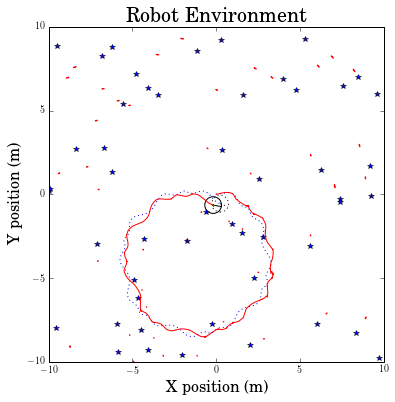

In [40]:
from matplotlib.patches import Ellipse

def plot_ellipse(loc, P):
    U, s, _ = np.linalg.svd(P)
    s = np.sqrt(5.991)*np.sqrt(s)
    alpha = np.arctan2(U[1, 0], U[0, 0])
    ellipse = Ellipse(loc, s[0], s[1], alpha*180/np.pi, ec='r', fill=False)
    return ellipse

def update_ellipse(ellipse, loc, P):
    U, s, _ = np.linalg.svd(P)
    s = np.sqrt(5.991)*np.sqrt(s)
    alpha = np.arctan2(U[1, 0], U[0, 0])
    ellipse.center = loc
    ellipse.width = s[0]
    ellipse.height = s[1]
    ellipse.angle = alpha*180/np.pi


plt.close('all')
env = plt.figure(figsize=(6, 6))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, -1], x[1, -1]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, -1], xHat[1, -1]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, -1])], [0, np.sin(x[2, -1])]])/2
line, = ax.plot(x[0, -1] + direction[0, :], x[1, -1] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, -1])], [0, np.sin(xHat[2, -1])]])/2
lineHat, = ax.plot(xHat[0, -1] + directionHat[0, :], xHat[1, -1] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'b*', markersize=6)
# featuresHat, = ax.plot(landmarksHat[0, :, -1], landmarksHat[1, :, -1], 'r*', markersize=10)
particles, = ax.plot(X[0, :, -1], X[1, :, -1], 'go', markersize=1.5, markeredgewidth=0.0)
ellipses = []
for j in xrange(num_landmarks):
    ell = plot_ellipse(landmarksHat[:, j, -1], landmark_P[:, :, j, -1])
    ell2 = plot_ellipse(landmarksHat[:, j, -1] - X[:2, best_idx[-1], -1] + x[:2, -1], landmark_P[:, :, j, -1])
    ax.add_artist(ell)
    ellipses.append(ell)
truth, = ax.plot(x[0, :], x[1, :], 'b:')
# estimate, = ax.plot(xHat[0, :], xHat[1, :], 'r')
estimate, = ax.plot(X[0, best_idx[-1], :], X[1, best_idx[-1], :], 'r')
plt.show()


In [41]:
plt.close('all')
env = plt.figure(figsize=(6, 6))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, 0], x[1, 0]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, 0], xHat[1, 0]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, 0])], [0, np.sin(x[2, 0])]])/2
line, = ax.plot(x[0, 0] + direction[0, :], x[1, 0] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, 0])], [0, np.sin(xHat[2, 0])]])/2
lineHat, = ax.plot(xHat[0, 0] + directionHat[0, :], xHat[1, 0] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'b*', markersize=5)
particles, = ax.plot(X[0, :, -1], X[1, :, -1], 'go', markersize=1.5, markeredgewidth=0.0)
# featuresHat, = ax.plot(landmarksHat[0, :, 0], landmarksHat[1, :, 0], 'r*', markersize=5)
ellipses = []
for j in xrange(num_landmarks):
    ell = plot_ellipse(landmarksHat[:, j, 0], landmark_P[:, :, j, 0])
    ax.add_artist(ell)
    ellipses.append(ell)
truth, = ax.plot(x[0, 0], x[1, 0], 'b:')
# estimate, = ax.plot(xHat[0, 0], xHat[1, 0], 'r')
estimate, = ax.plot(X[0, best_idx[0], :], X[1, best_idx[0], :], 'r')

# cart = np.array([zHat[0, 0]*np.cos(zHat[1, 0]+xHat[2, 0]), zHat[0, 0]*np.sin(zHat[1, 0]+xHat[2, 0])])
# measurement, = ax.plot([xHat[0, 0], xHat[0, 0] + cart[0]], [xHat[1, 0], xHat[1, 0] + cart[1]], 'y--')

# animation function. This is called sequentially
def animate(i):
    direction = np.array([[0, np.cos(x[2, i])], [0, np.sin(x[2, i])]])/2
    line.set_data(x[0, i] + direction[0, :], x[1, i] + direction[1, :])
    robot.center = x[0, i], x[1, i]
    directionHat = np.array([[0, np.cos(xHat[2, i])], [0, np.sin(xHat[2, i])]])/2
    lineHat.set_data(xHat[0, i] + directionHat[0, :], xHat[1, i] + directionHat[1, :])
    robotHat.center = xHat[0, i], xHat[1, i]
    truth.set_data(x[0, :i], x[1, :i])
#     estimate.set_data(xHat[0, :i], xHat[1, :i])
    estimate.set_data(X[0, best_idx[i], :i], X[1, best_idx[i], :i])
    particles.set_data(X[0, :, i], X[1, :, i])
#     featuresHat.set_data(landmarksHat[0, :, i], landmarksHat[1, :, i])
    for j in xrange(num_landmarks):
        if landmark_P[0, 0, j, i] != 1e10:
            update_ellipse(ellipses[j], landmarksHat[:, j, i], landmark_P[:, :, j, i])
    # measurement to first landmark
#     cart = np.array([zHat[0, i]*np.cos(zHat[1, i]+xHat[2, i]), zHat[0, i]*np.sin(zHat[1, i]+xHat[2, i])])
#     measurement.set_data([xHat[0, i], xHat[0, i] + cart[0]], [xHat[1, i], xHat[1, i] + cart[1]])
    return (line,)


# call the animator. blit=True means only re-draw the parts that have changed.
speedup = 1
anim = animation.FuncAnimation(env, animate, frames=len(t), interval=Ts*1000/speedup, blit=True)
# anim = animation.FuncAnimation(env, animate, frames=20, interval=Ts*1000/speedup, blit=True)

#print(animation.writers.list())
HTML(anim.to_html5_video())

Error norm = 11.6005656641


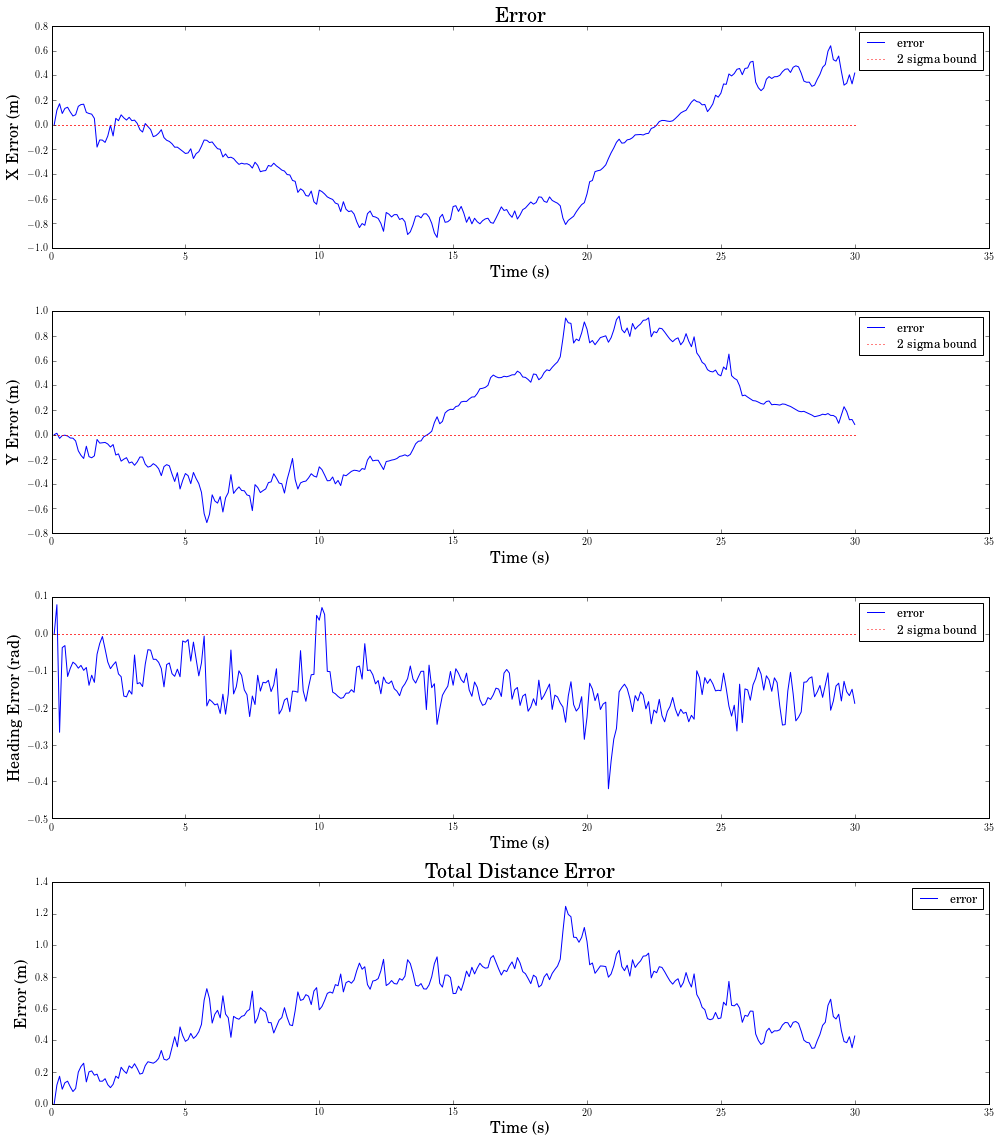

In [43]:
fig = plt.figure(figsize=(14,16))
fig.clear()

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(t, x[0, :] - xHat[0, :])
ax1.plot(t, 2*sig[0, :], 'r:')
ax1.plot(t, -2*sig[0, :], 'r:')
ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X Error (m)", fontsize=16)
# ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 2)
ax1.plot(t, x[1, :] - xHat[1, :])
ax1.plot(t, 2*sig[1, :], 'r:')
ax1.plot(t, -2*sig[1, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Y Error (m)", fontsize=16)
# ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 3)
ax1.plot(t, x[2, :] - xHat[2, :])
ax1.plot(t, 2*sig[2, :], 'r:')
ax1.plot(t, -2*sig[2, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Heading Error (rad)", fontsize=16)
# ax1.set_ylim([-0.2, 0.2])

ax1 = fig.add_subplot(4, 1, 4)
e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))
ax1.plot(t, e)
ax1.set_title("Total Distance Error",fontsize=20)
ax1.legend(["error"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Error (m)", fontsize=16)

print("Error norm = {}".format(np.linalg.norm(e)))

plt.tight_layout()
plt.show()

## Questions

* Q: How does the the system behave with poor initial conditions?
* A: The system converges within a few time steps, even with very poor initial conditions.

* Q: How does the system behave with changes in process/noise convariances?
* A: Increasing measurement noise increases estimation error and decreases the Kalman gains. Increasing process noise increases noise in truth, but marginally decreases estimation error. 

* Q: What happens to the quality of your estimates if you reduce the number of landmarks? increase?
* A: Fewer landmarks degrades the estimate. More landmarks marginally improves the localization unless the robot gets too close to a landmark, then it can cause it to diverge.

In [11]:
from tqdm import trange

Ts = 1
Tend = 20

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
x[:, 0] = np.array([-5, -3, np.pi/2])

N = 100
e = np.zeros(N)
for j in trange(N):
    # generate truth data
    for i in xrange(1, len(t)):
        x[:, i] = f(x[:, i-1], u[:, i], Ts)


    xHat = np.zeros_like(x)
    xHat[:, 0] = x[:, 0]
    sig = np.zeros_like(x)
    sig[:, 0] = np.sqrt(P.diagonal())
    K = np.zeros((3, 2, len(t)-1))
    input_dim = u.shape[0]
    ekf = EKF(xHat[:, 0], input_dim, f, g, del_f_x, del_g_x, R, P, Ts, del_f_u=del_f_u, Qu=Qu)

    zHat = np.zeros((2, len(t)))

    for i in xrange(1, len(t)):
        uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
        ekf.predict(uHat)
        for landmark in landmarks.T:
            z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
        #     zdeg = z - x[2, i]
        #     zdeg[1] = zdeg[1]*180/np.pi
        #     print(zdeg)
            zHat[:, i] = z
            ekf.update(z, landmark)
    #     landmark = landmarks[:, 0]
    #     z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
    #     ekf.update(z, landmark)
        xHat[:, i] = ekf.x
        K[:, :, i-1] = ekf.K
        sig[:, i] = np.sqrt(ekf.P.diagonal())


    e[j] = np.linalg.norm(np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2)))

print("Over {} runs:".format(N))
print("Mean error norm = {}".format(np.mean(e*Ts)))
print("Standard deviation of error norm = {}".format(np.std(e*Ts)))
    

100%|██████████| 100/100 [00:01<00:00, 72.99it/s]

Over 100 runs:
Mean error norm = 1.2002533331
Standard deviation of error norm = 0.333717604251


In [23]:
1/6.66

0.15015015015015015